# <center> **Tesina di Open Data Management 2022-2023**

<br>
<div align="center">
    <img src="op_wallpaper.jpg" width="1200" height="auto">

### <center> _Andrea Spinelli, Raffaele Terracino, Marco Valenti_
##### <center> 23 Giugno 

***
***

# __Indice__

###  [`1. - Traccia`](#1-traccia)
### [`2. - Selezione dei dataset`](#2-selezione-dei-dataset)
##### &emsp;&emsp; [`2.1 - Raccolta`](#21-raccolta)
##### &emsp;&emsp; [`2.2 - Licenze`](#22-licenze)
### [`3. - Elaborazione dei dataset`](#3-elaborazione-dei-dataset)
##### &emsp;&emsp; [`3.1 - Pulizia e selezione dei dati rilevanti`](#31-pulizia-e-selezione-dei-dati-rilevanti)
##### &emsp;&emsp; [`3.2 - Arricchimento`](#32-arricchimento)
### [`4. - Trasformazione dei dataset a 5 stelle`](#4-trasformazione-dei-dataset-a-5-stelle)
##### &emsp;&emsp; [`4.1 - Ontologia`](#41-ontologia)
##### &emsp;&emsp; [`4.2 - Passaggio a 5 stelle`](#42-passaggio-a-5-stelle)
### [`5. - Data visualization`](#5-data-visualization)
### [`6. - Creazione di un'applicazione`](#6-creazione-di-unapplicazione)

***
***
# __`1 Traccia`__

<u> Utilizzando il linguaggio Python, per lo sviluppo del progetto si devono innanzitutto rispettare i seguenti passi: </u>

- _Selezione dati;_
- _Elaborazione dati (data cleaning, definizione struttura omogenea);_
- _Open Linked Data (creazione di uno strato semantico, ontologie, interlinking)._
 
<u> Dopodiché si può passare, opzionalmente, allo sviluppo del servizio tramite: </u> 
- _Creazione di un bot telegram._

<u> Siano i seguenti dataset (forniti in allegato): </u>

__farmacie.csv,__

__parafarmacie.csv,__

__strutture_sanitarie_pubbliche.csv,__

__strutture_sanitarie_private.csv.__

<u> Si vuole realizzare un servizio in ambito “Salute” che fornisca le posizioni e le disponibilità delle strutture mediche nella regione siciliana. </u>

Si suppone che un utente del servizio abbia bisogno di dover andare a fare una visita dermatologica (struttura privata), oppure una visita ad un consultorio (struttura pubblica), tuttavia non conosce la posizione della struttura; quindi, può interrogare il servizio affinché possa trovare in un raggio di 𝑥 metri, data la sua posizione, un elenco (messaggio testuale, posizioni, …) di strutture specializzate nel campo desiderato. 

È possibile inoltre che l’utente, dopo una visita, abbia la prescrizione di alcuni farmaci; pertanto, avrà bisogno della locazione delle farmacie, o parafarmacie, più vicine. Il servizio di tale richiesta funziona allo stesso modo di quello precedente, inoltre si può fornire anche il recapito telefonico per effettuare la prenotazione dei farmaci. 

***
***
# __`2 Selezione dei dataset`__


### __`2.1 Raccolta`__

I dataset utilizzati per la realizzazione della base di conoscenza riguardano Farmacie, Parafarmacie, Strutture sanitarie Pubbliche, Strutture Sanitarie Private e la Popolazione residente in Sicilia nell'anno 2023. L'obiettivo della base di conoscenza è racchiudere tutti gli esercizi sanitari presenti in Sicilia.

L'ultimo dataset, in particolare, risulta fondamentale per raccontare una storia basandosi sugli altri dataset.

Seguono i link da cui sono stati reperiti i dataset

`Farmacie:` <br>
_https://www.dati.salute.gov.it/dati/dettaglioDataset.jsp?menu=dati&idPag=5_

`Parafarmacie:` <br>
_https://www.dati.salute.gov.it/dati/dettaglioDataset.jsp?menu=dati&idPag=7_

`Strutture Sanitarie Pubbliche:` <br>
_https://dati.regione.sicilia.it/catalogo/da5a0f1f-82b4-472f-b3dd-458295983a97_

`Strutture Sanitarie Private:` <br>
_http://pti.regione.sicilia.it/portal/page/portal/PIR_PORTALE/PIR_LaStrutturaRegionale/PIR_AssessoratoSalute/PIR_DipPianificazioneStrategica/PIR_Infoedocumenti/PIR_8713479.360776903/PIR_Strutturesanitarieprivateaccreditate_

`Popolazione Sicilia, 1 Gen 2023:` <br>
_http://dati.istat.it/Index.aspx?QueryId=19101_

***
Per l'ultimo dataset si è scelta una versione personalizzata, realizzata mediante le funzioni di personalizzazione presenti nella pagina web. Il dataset risultante contiene, la denominazione e la popolazione totale residente per ogni comune. <br>
I dataset descritti sono contenuti all'interno della cartella `../datasets/csv/original/`

### __`2.2 Licenze`__

`Farmacie:` Italian Open Data Licence v2.0

`Parafarmacie:` Italian Open Data Licence v2.0

`Strutture Sanitarie Pubbliche:` Creative Commons BY, versione 4.0

`Strutture Sanitarie Private:` Licenza specificata nel decreto legislativo n. 33/2013, che specifica che "documenti, le informazioni e i dati oggetto di pubblicazione obbligatoria ai sensi della normativa vigente, resi disponibili anche a seguito dell'accesso civico di cui all'articolo 5, sono pubblicati in formato di tipo aperto ai sensi dell'articolo 68 del Codice dell'amministrazione digitale, di cui al decreto legislativo 7 marzo 2005, n. 82, e sono riutilizzabili ai sensi del decreto legislativo 24 gennaio 2006, n. 36, del decreto legislativo 7 marzo 2005, n. 82, e del decreto legislativo 30 giugno 2003, n. 196, senza ulteriori restrizioni diverse dall'obbligo di citare la fonte e di rispettarne l'integrità"

`Popolazione Sicilia, 1 Gen 2023:` Creative Commons BY, versione 3.0 (specificato al link https://www.istat.it/it/note-legali)

***
***
# __`3 Elaborazione dei dataset`__

### __`3.1 Pulizia e selezione dei dati rilevanti`__

Si è notato innanzitutto che i dataset puri non erano tutti adatti allo stesso modo, infatti, si sono riscontrate due problematiche:
1. Encoding dei dataset differenti, a causa delle loro diversi origini;
2. Errori vari dovuti a `;` o `,` non correttamente inseriti.

La problematica 1. si è riscontrata a causa degli errori di lettura dei file `CSV` da parte del metodo `read_csv()` di `Pandas`, inoltre se ne è veriificata la veridicità tramite il comando `file` di Unix.<br>
Per ovviare a tale problema si è deciso prima di tutto come encoding più adatto ai dataset scelti l'`UTF-8`, dopodiché si è passati alla conversione dell'encoding dei file tramite un convertitore online che, ????? in quanto i file `CSV` sono alla base dei testi, non ha generato problemi problemi di conversione nei dataset.

La problematica 2. si è riscontrata tramite lettura e osservazioni preventive all'uso dei dataset, i quali quest'ultimi presentavano errori di compiliazioni facilmente individuabili, appunto, si è fatto semplice uso dello strumento `Find and Replace`.

Gli strumenti adoperati per la pulizia dei dataset includono `frictionless`, `Open Refine`, l'estensione `Edit csv` di `VS Code` e `Microsoft Excel`.

I dataset relativi a questa prima elaborazione sono stati raccolti in: `../datasets/csv/cleaned/`. <br>

Proseguendo con l'elaborazione dei dataset, sono seguite altre osservazioni:
1. una buona parte delle righe dei dataset riguardanti le farmacie e parafarmacie presentavano dati di regioni aggiuntive oltre la Sicilia;
2. I datascelt scelti presentavano, per lo stesso motivo, colonne superflue per la base di conoscenza da realizzare;
3. i dataset riguardanti parafarmacie, farmacie e strutture pubbliche presentavano dati riguardo esercizi non più attivi, che non sono di interesse per la base di conoscenza da realizzare.

Le problematiche descritte sono state risolte mediante lo strumento `Open Refine`, attraverso le funzioni `Text Filter` e `Remove Column`. <br>
Per la prima è stato sufficiente selezionare le righe che presentavano `Sicilia` come campo di `Regione`,rimuovendo le altre, per la seconda è stato sufficiente eliminare alcune delle colonne tra i vari dataset, come quelle indicanti codici dell'istat,  mentre per per la terza è bastato prendere le righe per cui fosse vuoto il campo indicante la data di chiusura dell'esercizio. <br>

Questa seconda elaborazione dei dataset è stata riportata in: `../datasets/csv/selected/`.

***

### __`3.2 Arricchimento`__

Successiva alla fase di pulizia e selezione, si è introdotta una fase di arricchimento dei dataset.

Tale scelta è stata effettuata dopo varie osservazioni preventive per le fasi successive dei dataset, per facilitare lo sviluppo dell'ontologia e il passaggio dei dataset a 5 stelle. Difatti, dopo tali operazioni di arricchimento, tutti i dataset sugli esercizi sanitari presentano campi comuni, fatto che agevola la realizzazione di una gerarchia di classi OWL.

La prima operazione riguarda il dataset dei comuni, a cui vengono aggiunte le provincie tramite un merge con il dataset delle farmacie. Tale operazione restituisce un dataset contenente tutti e soli i comuni in cui vi è almeno una farmacia. Un numero molto piccolo di comuni viene pertanto escluso. Si suppone pertanto che se un comune è tale da non avere nemmeno una farmacia, sicuramente non vi saranno nè parafarmacie nè strutture sanitarie di alcun tipo.

In [2]:
import pandas as pd

comuni = pd.read_csv("../datasets/csv/selected/popolazione_sicilia.csv", sep=',', skiprows=[1])
farmacie = pd.read_csv('../datasets/csv/cleaned/farmacie.csv', sep=';') #si prende quello cleaned per considerare più comuni possibili

#operazioni di replace per consentire la compatibilità tra i due dataset
comuni['Territorio'] = comuni['Territorio'].apply(lambda x : x.title().replace('à', 'a\'').replace('è', 'e\'').replace('ì', 'i\'').replace('ò', 'o\'').replace('ù', 'u\''))
farmacie['DESCRIZIONECOMUNE'] = farmacie['DESCRIZIONECOMUNE'].apply(lambda x : x.title())
joined = comuni.merge(farmacie, left_on='Territorio', right_on='DESCRIZIONECOMUNE')

df2=joined.drop_duplicates(subset=['Territorio'], keep='first')

df3=df2.rename(columns={"Territorio": "Comune", "Value": "PopolazioneTotale", "DESCRIZIONEPROVINCIA" : "Provincia", "SIGLAPROVINCIA":"SiglaProvincia"})
df3.to_csv('../datasets/csv/completed/comuni_sicilia.csv', columns=['Comune', 'PopolazioneTotale', 'Provincia', 'SiglaProvincia'], index=False)

I successivi arricchimenti riguardano il resto dei dataset. Si fa in modo che ognuno di essi contenga informazioni sul comune, latitudine, longitudine e cap. In questa fase si è fatto uso della libreria `OSMPythonTools.nominatim` che offre la possibilità di interrogare OpenStreetMap. Inoltre, fornisce un servizio di caching molto vantaggioso all'uso in quanto, fatta una serie di richieste, salva tutti i dati in una cartella a parte che, in caso di medesime richieste successive, riduce il tempo di esecuzione delle query. <br>


Creazione dei dataframe a partire dai csv

In [10]:
import pandas as pd

df_private = pd.read_csv("../datasets/csv/selected/strutture_sanitarie_private.csv", on_bad_lines="skip", delimiter=";", encoding="utf-8")
df_pubbliche = pd.read_csv("../datasets/csv/selected/strutture_sanitarie_pubbliche.csv", on_bad_lines="skip", delimiter=",", encoding="utf-8")
df_farma = pd.read_csv("../datasets/csv/selected/farmacie.csv", on_bad_lines="skip", delimiter=",", encoding="utf-8")

df_private.columns = df_private.columns.str.strip()
df_pubbliche.columns = df_pubbliche.columns.str.strip()
df_farma.columns = df_farma.columns.str.strip()

Si aggiugono `CAP`, `Latitudine` e `Longitudine` alle strutture private:

In [11]:
from OSMPythonTools.nominatim import Nominatim
from pathlib import Path
import pandas as pd
import re

nominatim = Nominatim()
results = []

LOC = []
LAT = []
LON = []

for via, citta in zip(df_private["Indirizzo"], df_private["Citta\'"]):
    
    via = str(via).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')
    citta = str(citta).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')

    res = nominatim.query(via + " " + citta)
    results.append(res)

for item in results:
    tmp = item.toJSON()
    if len(tmp) != 0:
        LAT.append(tmp[0]['lat'])
        LON.append(tmp[0]['lon'])
        cap = re.search(r'\d{5}',tmp[0]['display_name'])
        if cap is not None:
            LOC.append(cap.group())
        else:
            LOC.append(0)
    else:
        LAT.append(0.0)
        LON.append(0.0)
        LOC.append(0)
            
df_private.insert(loc=0, column='Longitudine', value=pd.Series(LON))
df_private.insert(loc=0, column='Latitudine', value=pd.Series(LAT))
df_private.insert(loc=0, column='CAP', value=pd.Series(LOC))

filepath = Path('../datasets/csv/completed/private.csv')
df_private.to_csv(filepath, index=False)

Si aggiugono `Comune`, `Latitudine` e `Longitudine` alle strutture pubbliche:

In [12]:
from OSMPythonTools.nominatim import Nominatim
from pathlib import Path
import pandas as pd
import re

nominatim = Nominatim()
results = []

COM = []
LAT = []
LON = []

for via, cap in zip(df_pubbliche["Indirizzo"], df_pubbliche["CAP"]):
    
    via = str(via).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')
    cap = str(cap).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')

    res = nominatim.query(via + " " + cap)
    results.append(res)
    
for item in results:
    tmp = item.toJSON()
    if len(tmp) != 0:
        LAT.append(tmp[0]['lat'])
        LON.append(tmp[0]['lon'])
        com = re.search(r', (\w*), Sicilia',tmp[0]['display_name'])
        if com is not None:
            COM.append(com[1])
        else:
            COM.append("")
    else:
        LAT.append(0.0)
        LON.append(0.0)
        COM.append("")
            
df_pubbliche.insert(loc=0, column='Longitudine', value=pd.Series(LON))
df_pubbliche.insert(loc=0, column='Latitudine', value=pd.Series(LAT))
df_pubbliche.insert(loc=0, column='Comune', value=pd.Series(COM))

filepath = Path('../datasets/csv/completed/pubbliche.csv')
df_pubbliche.to_csv(filepath, index=False)

Si rielaborano i campi `LATITUDINE` e `LONGITUDINE` di `farmacie.csv`, in quanto una parte delle righe mancano di tali informazioni. <br>
Si inseriscono in un CSV temporaneo i dati mancanti, si rielaborano allo stesso modo dei due file precedenti, sovracrivendo i campi esistenti, concatenandoli poi con il file originale:

In [8]:
from OSMPythonTools.nominatim import Nominatim
from pathlib import Path
import pandas as pd

df_farma_tmp = pd.read_csv("../datasets/csv/selected/farmacie_tmp.csv", on_bad_lines="skip", encoding="utf-8")

nominatim = Nominatim()
results = []

LAT = []
LON = []

for via, citta in zip(df_farma_tmp["INDIRIZZO"], df_farma_tmp["DESCRIZIONECOMUNE"]):

    via = str(via).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')
    citta = str(citta).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')

    res = nominatim.query(via + "," + citta)
    results.append(res)

for item in results:
    tmp = item.toJSON()
    if len(tmp) != 0:
        LAT.append(tmp[0]['lat'])
        LON.append(tmp[0]['lon'])
    else:
        LAT.append(0.0)
        LON.append(0.0)

df_farma_tmp["LONGITUDINE"] = pd.Series(LON)
df_farma_tmp["LATITUDINE"] = pd.Series(LAT)

###

df_farma["LATITUDINE"] = df_farma["LATITUDINE"].apply(lambda x : float(x.replace(',', '.')) if x != '-' else 0.0)
df_farma["LONGITUDINE"] = df_farma["LONGITUDINE"].apply(lambda x : float(x.replace(',', '.')) if x != '-' else 0.0)
df_farma["PARTITAIVA"] = df_farma["PARTITAIVA"].apply(lambda x : x if x != "-" else 0)
df_farma["INDIRIZZO"] = df_farma["INDIRIZZO"].apply(lambda x : x.replace('"', ''))

filepath = Path('../datasets/csv/selected/tmp.csv')
df_farma_tmp.to_csv(filepath, index=False)
df_farma_tmp = pd.read_csv("../datasets/csv/selected/tmp.csv", on_bad_lines="skip", encoding="utf-8")

###

df_farma = df_farma.convert_dtypes()
df_farma_tmp = df_farma_tmp.convert_dtypes()

df_farma = df_farma.drop(df_farma.loc[448:].index)
df_finale = pd.merge(df_farma, df_farma_tmp, how="outer")

filepath = Path('../datasets/csv/completed/farmacie.csv')
df_finale.to_csv(filepath, index=False)

Il salvataggio del dataset con i tipi corretti in un ulteriore file temporaneo è necessario per il corretto funzionamento della funzione `merge` di `Pandas`.

Le operazioni descritte rendono i dataset pronti per le 5 stelle, salvandoli nella cartella `../datasets/csv/completed`

***
***
# __`4 Trasformazione dei dataset a 5 stelle`__

### __`4.1 Ontologia`__

L'ontologia progettata è un'ontologia `OWL` realizzata con il software `Protégé`. La progettazione è partita da due classi base, `Comune` e `AziendaSanitaria`. Per la classe `Comune` sono state definite le proprietà `hasName`, `hasTotalPopulation`, `hasProvince` e `hasProvinceAcr`. La classe `AziendaSanitaria` è alla base di una gerarchia per la definizione delle proprietà degli altri 4 dataset. Le proprietà comuni ai 4 dataset sono `hasName`, `hasAddress`, `hasCap`, `hasLatitude`, `hasLongitude`, `isIn` e `hasSite`. <br>
Nell'analisi dei dataset ci si è accorti della presenza di esercizi con la stessa denominazione e partita IVA, ovvero con più sedi. Si è quindi rilevato il problema delle relazioni multi valore, risolvibile mediante i blank nodes. La proprietà `hasSite` permette tale approccio, inglobando le altre proprietà citate. La object property `isIn` ha come range `Comune`. In questo modo è possibile ridurre l'informazione a carico degli esercizi commerciali, poichè presentano anche informazioni sulla provincia del comune in cui sono localizzati. Come esempio, si supponga di voler sapere, per ogni farmacia, le informazioni del comune in cui è localizzata. La seguente query `SPARQL` svolge tale compito:

La classe madre `AziendaSanitaria` si scompone in due classi, `NegozioSanitario` e `StrutturaSanitaria`. `NegozioSanitario` a sua volta si scompone in `Farmacia` e `Parafarmacia`, mentre `StrutturaSanitaria` in `StrutturaPrivata` e `StrutturaPubblica`. `NegozioSanitario` include le proprietà comuni sia alle farmacie che alle parafarmacie. Rispetto a `Parafarmacia`, la classe `Farmacia` incapsula una proprietà in più, ossia `tipology`, rappresentante del fatto che una farmacia può essere ordinaria oppure un dispensario. Similmente `StrutturaSanitaria` incapsula le proprietà comuni alle strutture pubbliche e private, mentre le sue sottoclassi aggiungono le proprietà specifiche di entrambi i tipi. <br> La proprietà `hasSite` assume una valenza diversa in base alla risorsa cui si riferisce. Il numero di proprietà inglobate nel blank node varia in base alla risorsa. Per esempio, ogni sede di una struttura sanitaria può avere un distinto numero di telefono o email, pertanto si è deciso di inglobare anche proprietà simili nel blank node.

L'ontologia descritta è stata serializzata nel formato `ttl` ed è stata riportata in: `../ontologies/ontologia_sanita.ttl`. <br>
L'URI dell'ontologia è http://www.sanitasicilia.it/ontology.


***

### __`4.2 Passaggio a 5 stelle`__

Per il passaggio dei dataset da 3 a 5 stelle ci si è basati sullo standard RDF di W3C, congiunta con la libreria `rdflib` di Python.

Il primo step è stata l'inizializzazione del grafo RDF e dei namespace di interesse. <br>
Per identificare le risorse, a partire dall'URI di base "http://www.sanitasicilia.it/resource/" si sono fatte le seguenti scelte:
- Per i comuni si è scelta la denominazione come identificativo, togliendo da essa apostrofi e spazi; 
- Per le risorse rimanenti si è scelti un identificativo costituito dalle iniziali della categorie della risorsa e da un codice a 4 cifre, indicante la riga in cui quella risorsa compare nel dataset originale.

Per ogni colonna di ogni dataset si aggiunge al grafo una tripla, facendo riferimento all'omonima proprietà definita nell'ontologia. Inoltre, per gli esercizi con la stessa partita IVA e denominazione, si aggiunge un blank node come descritto nella sezione precedente.

Per quanto riguarda l'interlinking viene sfruttata la base di conoscenza dbpedia.org. Dapprima, attraverso una query SPARQL, per ogni comune si crea un collegamento con l'omonima risorsa presente su dbpedia; dopodiché, sfruttando la proprietà `owl:sameAs` della risorsa su dbpedia, si realizza l'interlinking con `wikidata` e `geonames`.

In [1]:
import urllib.parse
import pandas as pd
import math
from rdflib import Graph, Literal, Namespace, URIRef, BNode
from rdflib.namespace import RDF, OWL, XSD
from SPARQLWrapper import SPARQLWrapper, JSON

g = Graph()

base_uri = "http://www.sanitasicilia.it/resource/"

sso = Namespace("http://www.sanitasicilia.it/ontology/")
g.bind("sso", sso)

ssr = Namespace("http://www.sanitasicilia.it/resource/")
g.bind("ssr", ssr)

def urify(uri, res):
    res = res.replace(" ","_").replace("\'","")
    return uri + urllib.parse.quote(res)

#### Comuni

In [ ]:
def interlinkToDbpedia(res, comune):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
        SELECT ?res ?label
        WHERE {{
            ?res dbo:region dbr:Sicily .
            ?res rdfs:label ?label . 
            FILTER(LANG(?label)="it")
            FILTER REGEX(?label, "^{comune}", 'i') .
        }}
    """

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    if len(results["results"]["bindings"]) > 0:
        result = results["results"]["bindings"][0]
        g.add( [res, OWL.sameAs, URIRef(result["res"]["value"])])
  
def interlinkToWikidata(res, comune):

    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""SELECT ?res ?link
                WHERE {{
                    ?res dbo:region dbr:Sicily .
                    ?res rdfs:label ?label .
                    FILTER(LANG(?label)="it") .
                    FILTER REGEX(?label, "^{comune}", 'i') .
                    ?res owl:sameAs ?link .
                    FILTER REGEX(?link, 'wikidata', 'i') .
                }}
                LIMIT 1
            """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    if len(results["results"]["bindings"]) > 0:
        result = results["results"]["bindings"][0]
        g.add( [res, OWL.sameAs, URIRef(result["link"]["value"])])

def interlinkToGeonames(res, comune):

    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""SELECT ?res ?link
                WHERE {{
                    ?res dbo:region dbr:Sicily .
                    ?res rdfs:label ?label .
                    FILTER(LANG(?label)="it") .
                    FILTER REGEX(?label, "^{comune}", 'i') .
                    ?res owl:sameAs ?link .
                    FILTER REGEX(?link, 'geonames', 'i') .
                }}
                LIMIT 1
            """

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    if len(results["results"]["bindings"]) > 0:
        result = results["results"]["bindings"][0]
        g.add( [res, OWL.sameAs, URIRef(result["link"]["value"])])

def addTriples(row):
    res = URIRef(urify(base_uri, row[0]))
    g.add([res, URIRef(RDF.type), URIRef(sso.Comune)])
    g.add([res, sso.hasName, Literal(row[0], datatype=XSD.string)])
    g.add([res, sso.hasTotalPopulation, Literal(row[1], datatype=XSD.integer)])
    g.add([res, sso.hasProvince, Literal(row[2], datatype=XSD.string)])
    g.add([res, sso.hasProvinceAcr, Literal(row[3], datatype=XSD.string)])

    #interlinking
    comune = row[0].replace('a\'', 'à').replace('o\'', 'ò').replace('e\'', 'è').replace('i\'', 'ì').replace('u\'', 'ù').title()
    interlinkToDbpedia(res, comune)
    interlinkToWikidata(res, comune)
    interlinkToGeonames(res, comune)

count = 0 
comuni_df = pd.read_csv("../datasets/csv/completed/comuni_sicilia.csv")

comuni_df.apply(lambda row : addTriples(row), axis=1)

#### Farmacie

In [ ]:
def addBNodes(res, row):
    bn = BNode()

    g.add([res, sso.hasSite, bn])
    g.add([bn, sso.hasAddress, Literal(row[0], datatype=XSD.string)])
   
    if(row[3] != 0):
        g.add([bn, sso.hasCap, Literal(row[3], datatype=XSD.integer)])
    g.add([bn, sso.isIn, URIRef(urify(base_uri, row[4].title()))])
    g.add([bn, sso.tipology, Literal(row[7], datatype=XSD.string)])
    
    if(row[8] != 0 and row[9] != 0):
        g.add([bn, sso.hasLatitude, Literal(row[8], datatype=XSD.decimal)])
        g.add([bn, sso.hasLongitude, Literal(row[9], datatype=XSD.decimal)])

def addTriples(row):
    global count
    
    if not row_prev.empty:
        if row_prev[1] == row[1] and row_prev[2] == row[2]:
            code = 'PF'+f'{count-1:04}'
            addBNodes(URIRef(urify(base_uri, code)), row)
            return

    code = 'F'+f'{count:04}'
    
    res = URIRef(urify(base_uri, code))
    g.add([res, URIRef(RDF.type), URIRef(sso.Farmacia)])

    g.add([res, sso.hasName, Literal(row[1], datatype=XSD.string)])
    g.add([res, sso.hasVatNumber, Literal(row[2], datatype=XSD.integer)])

    addBNodes(URIRef(urify(base_uri, code)), row)
    count = count + 1

count = 0
row_prev = pd.Series()

farmacie_df = pd.read_csv("../datasets/csv/completed/farmacie.csv")

farmacie_df["PARTITAIVA"] = farmacie_df["PARTITAIVA"].astype(int)

farmacie_df.apply(lambda row : addTriples(row), axis=1)

#### Parafarmacie

In [ ]:
def addBNodes(res, row):
    bn = BNode()

    g.add([res, sso.hasSite, bn])
    g.add([bn, sso.hasAddress, Literal(row[1], datatype=XSD.string)])
   
    if(row[3] != 0):
        g.add([bn, sso.hasCap, Literal(row[3], datatype=XSD.integer)])
    g.add([bn, sso.isIn, URIRef(urify(base_uri, row[4].title()))])

    if(row[7] != 0 and row[8] != 0):
        g.add([bn, sso.hasLatitude, Literal(row[7], datatype=XSD.decimal)])
        g.add([bn, sso.hasLongitude, Literal(row[8], datatype=XSD.decimal)])

def addTriples(row):
    global count, row_prev

    if not row_prev.empty:
        if row_prev[0] == row[0] and row_prev[2] == row[2]:
            code = 'PF'+f'{count-1:04}'
            addBNodes(URIRef(urify(base_uri, code)), row)
            return
    
    code = 'PF'+f'{count:04}'

    row_prev = pd.Series(row)

    res = URIRef(urify(base_uri, code))
    g.add([res, URIRef(RDF.type), URIRef(sso.Parafarmacia)])

    g.add([res, sso.hasName, Literal(row[0], datatype=XSD.string)])
    g.add([res, sso.hasVatNumber, Literal(row[2], datatype=XSD.integer)])

    addBNodes(URIRef(urify(base_uri, code)), row)
    count = count + 1

count = 0
row_prev = pd.Series()

parafarmacie_df = pd.read_csv("../datasets/csv/completed/parafarmacie.csv")

parafarmacie_df["LATITUDINE"] = parafarmacie_df["LATITUDINE"].apply(lambda x : float(x.replace(',', '.')) if x != '-' else 0.0)
parafarmacie_df["LONGITUDINE"] = parafarmacie_df["LONGITUDINE"].apply(lambda x : float(x.replace(',', '.')) if x != '-' else 0.0)
parafarmacie_df["PARTITAIVA"] = parafarmacie_df["PARTITAIVA"].apply(lambda x : x if x != '-' else 0)
parafarmacie_df["PARTITAIVA"] = parafarmacie_df["PARTITAIVA"].astype(int)

parafarmacie_df.apply(lambda row : addTriples(row), axis=1)

#### Strutture sanitarie private

In [ ]:
def addBNodes(res, row):
    bn = BNode()

    g.add([res, sso.hasSite, bn])
    g.add([bn, sso.hasAddress, Literal(row[6], datatype=XSD.string)])
   
    if(row[0] != 0):
        g.add([bn, sso.hasCap, Literal(row[0], datatype=XSD.integer)])
    g.add([bn, sso.isIn, URIRef(urify(base_uri, row[5].title()))])

    if(row[1] != 0 and row[2] != 0):
        g.add([bn, sso.hasLatitude, Literal(row[1], datatype=XSD.decimal)])
        g.add([bn, sso.hasLongitude, Literal(row[2], datatype=XSD.decimal)])

    g.add([bn, sso.businessType, Literal(row[8], datatype=XSD.string)])
    g.add([bn, sso.hasSiteType, Literal(row[9], datatype=XSD.string)])

def addTriples(row):
    global count, row_prev

    if not row_prev.empty:
        if row_prev[7] == row[7]:
            code = 'SPVT'+f'{count-1:04}'
            addBNodes(URIRef(urify(base_uri, code)), row)
            return
    
    code = 'SPVT'+f'{count:04}'

    row_prev = pd.Series(row)

    res = URIRef(urify(base_uri, code))
    g.add([res, URIRef(RDF.type), URIRef(sso.StrutturaPrivata)])

    g.add([res, sso.hasName, Literal(row[7], datatype=XSD.string)])
    g.add([res, sso.hasReferenceAsp, Literal(row[3], datatype=XSD.string)])
    addBNodes(URIRef(urify(base_uri, code)), row)
    count = count + 1

count = 0
row_prev = pd.Series()

private_df = pd.read_csv("../datasets/csv/completed/private.csv")

private_df["Citta\'"] = private_df["Citta\'"].astype(str)

private_df.apply(lambda row : addTriples(row), axis=1)


#### Strutture sanitarie pubbliche

In [ ]:
def addBNodes(res, row):
    bn = BNode()

    g.add([res, sso.hasSite, bn])
   
    if(row[0] != ''):
        g.add([bn, sso.isIn, URIRef(urify(base_uri, row[0].title()))])

    if(row[1] != 0 and row[2] != 0):
        g.add([bn, sso.hasLatitude, Literal(row[1], datatype=XSD.decimal)])
        g.add([bn, sso.hasLongitude, Literal(row[2], datatype=XSD.decimal)])
   
    g.add([bn, sso.hasCap, Literal(row[3], datatype=XSD.integer) ])
    g.add([bn, sso.hasAddress, Literal(row[4], datatype=XSD.string)])
    g.add([bn, sso.businessType, Literal(row[6], datatype=XSD.string)])
    g.add([bn, sso.hasSiteType, Literal(row[7], datatype=XSD.string)])

    if row[8] != 'nan':
        g.add([bn, sso.isRecoveryStructure, Literal(True, datatype=XSD.boolean)])
        g.add([bn, sso.hasRecoveryStructureName, Literal(row[8], datatype=XSD.string)])
    else:
        g.add([bn, sso.isRecoveryStructure, Literal(False, datatype=XSD.boolean)])

    g.add([bn, sso.workingMonths, Literal(row[9], datatype=XSD.integer)])
    g.add([bn, sso.openingDays, Literal(row[10], datatype=XSD.integer)])
    g.add([bn, sso.weeklyHours, Literal(row[11], datatype=XSD.integer)])
    g.add([bn, sso.hasEmail, Literal(row[13], datatype=XSD.string)])

    if row[14] != 'nan':
        g.add([bn, sso.hasWebsite, Literal(row[14], datatype=XSD.string)])
   
    if not math.isnan(row[15]):
        g.add([bn, sso.hasPhonePrefix, Literal(row[15], datatype=XSD.integer)])
   
    if not math.isnan(row[16]):
        g.add([bn, sso.hasPhoneNumber, Literal(row[16], datatype=XSD.integer)])
    
    if row[17] != 0:
        g.add([bn, sso.hasFaxPrefix, Literal(row[17], datatype=XSD.integer)])
    
    if row[18] != 0:
        g.add([bn, sso.hasFaxNumber, Literal(row[18], datatype=XSD.integer)])

def addTriples(row):
    global count, row_prev

    if not row_prev.empty:
        if row_prev[5] == row[5] and row_prev[12] == row[12]:
            code = 'SPUB'+f'{count-1:04}'
            addBNodes(URIRef(urify(base_uri, code)), row)
            return
    
    row_prev = pd.Series(row)
    code = 'SPUB'+f'{count:04}'
    res = URIRef(urify(base_uri, code))
    g.add([res, URIRef(RDF.type), URIRef(sso.StrutturaPubblica)])
    g.add([res, sso.hasName, Literal(row[5], datatype=XSD.string) ])
    if row[12] != 0:
        g.add([res, sso.hasVatNumber, Literal(row[12], datatype=XSD.integer)])

    addBNodes(res, row)
    count = count + 1

count = 0
row_prev = pd.Series()

pubbliche_df = pd.read_csv("../datasets/csv/completed/pubbliche.csv")

pubbliche_df["Comune"] = pubbliche_df["Comune"].astype(str)
pubbliche_df["Denominazione struttura di ricovero"] = pubbliche_df["Denominazione struttura di ricovero"].astype(str)
pubbliche_df["Sito web"] = pubbliche_df["Sito web"].astype(str)
pubbliche_df["Partita IVA"] = pubbliche_df["Partita IVA"].apply(lambda x : x if not math.isnan(x) else 0)
pubbliche_df["Partita IVA"] = pubbliche_df["Partita IVA"].astype(int)
pubbliche_df["Prefisso fax"] = pubbliche_df["Prefisso fax"].apply(lambda x : x if not math.isnan(x) else 0)
pubbliche_df["Prefisso fax"] = pubbliche_df["Prefisso fax"].astype(int)
pubbliche_df["Numero fax"] = pubbliche_df["Numero fax"].apply(lambda x : x if not math.isnan(x) else 0)
pubbliche_df["Numero fax"] = pubbliche_df["Numero fax"].astype(int)

pubbliche_df.apply(lambda row : addTriples(row), axis=1)

####
Si effettua la serializzazzione nei formati `xml` e `ttl`

In [ ]:
g.serialize(destination='../datasets/rdf/sanitasicilia.xml', format='xml')
g.serialize(destination='../datasets/rdf/sanitasicilia.ttl', format='ttl')

***
***
# __`5 Data visualization`__

Dopo aver riportati i dataset a 5 stelle, con gli strumenti utilizzati finora, si è scoperto che:
- Il numero di farmacie, nell'anno corrente, è quasi al pari numero di parafarmacie in tutte le provincie siciliane, eccetto per Catania e Messina che presentano un numero maggiore di parafarmacie nei loro territori.
- Il numero di strutture private sono maggiori per tutto il territorio siciliano. Si preferisce quindi fare richiesta a medici specializzati privati per ovviare le attese nei locali pubblici.
- In media, nell'anno corrente, il numero di farmacie e parafarmacie è equamente distribuito nelle varie provincie, in rapporto tra territorio e popolazione, dove: nelle provincie con un basso numero di farmacie e parafarmacie (riferimento grafico 1) ciascuna ha una distribuzione alta della popolazione; viceversa, nelle provincie con un alto numero di farmacie e parafarmacie (riferimento grafico 1) ciascuna ha una distribuzione bassa della popolazione. 

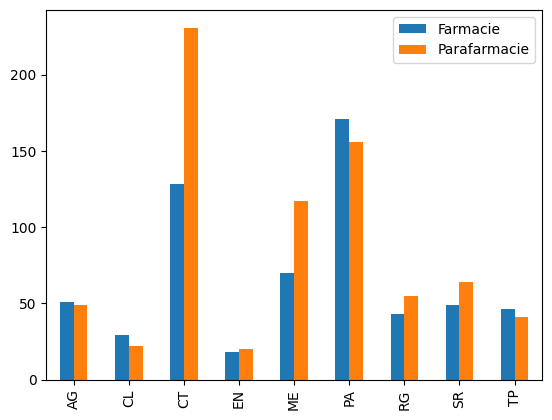

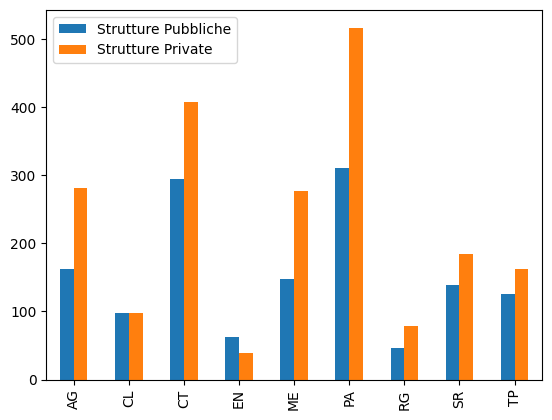

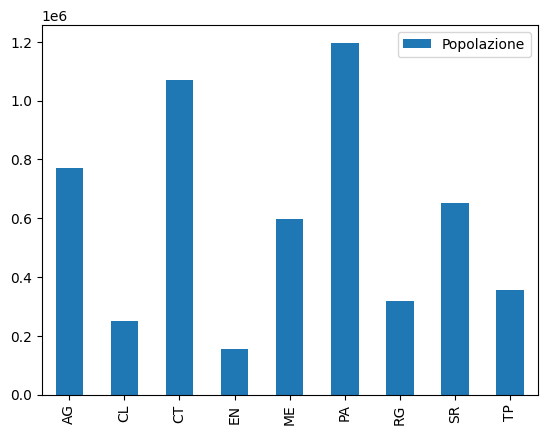

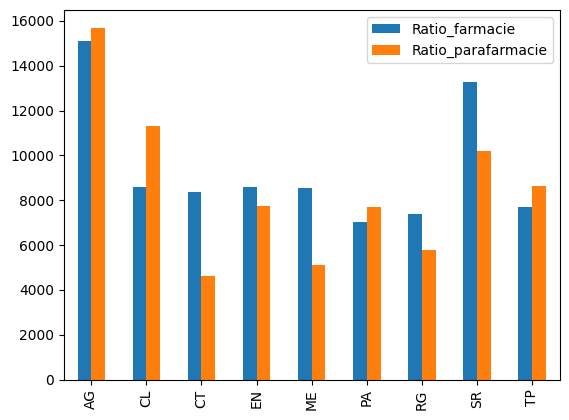

In [23]:
import pandas as pd
from rdflib import *

base_uri = "http://www.sanitasicilia.it/resource/"
g = Graph()

sso = Namespace("http://www.sanitasicilia.it/ontology/")
g.bind("sso", sso)

ssr = Namespace("http://www.sanitasicilia.it/resource/")
g.bind("ssr", ssr)

g.parse('../datasets/rdf/sanitasicilia.xml')

res = g.query(""" 
            SELECT ?prov (SUM(?pop) AS ?tot)
            WHERE {
                ?res rdf:type sso:Comune .
                ?res sso:hasTotalPopulation ?pop .
                ?res sso:hasProvinceAcr ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

provincie = [str(i[0]) for i in res]
population = [int(i[1]) for i in res]

res = g.query(""" 
            SELECT ?prov (COUNT(?res) AS ?count)
            WHERE {
                ?res rdf:type sso:Farmacia .
                ?res sso:hasSite ?site .
                ?site sso:isIn ?comune .
                ?comune sso:hasProvince ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

num_farmacie = [int(i[1]) for i in res]
prov_farmacie = [str(i[0]) for i in res]

res = g.query(""" 
            SELECT ?prov (COUNT(?res) AS ?count)
            WHERE {
                ?res rdf:type sso:Parafarmacia .
                ?res sso:hasSite ?site .
                ?site sso:isIn ?comune .
                ?comune sso:hasProvince ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

num_parafarmacie = [int(i[1]) for i in res]
prov_parafarmacie = [str(i[0]) for i in res]

res = g.query(""" 
            SELECT ?prov (COUNT(?res) AS ?count)
            WHERE {
                ?res rdf:type sso:StrutturaPrivata .
                ?res sso:hasSite ?site .
                ?site sso:isIn ?comune .
                ?comune sso:hasProvince ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

num_private = [int(i[1]) for i in res]
prov_private = [str(i[0]) for i in res]

res = g.query(""" 
            SELECT ?prov (COUNT(?res) AS ?count)
            WHERE {
                ?res rdf:type sso:StrutturaPubblica .
                ?res sso:hasSite ?site .
                ?site sso:isIn ?comune .
                ?comune sso:hasProvince ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

num_pubbliche = [int(i[1]) for i in res]
prov_pubbliche = [str(i[0]) for i in res]

ratios_farmacie = []
for i in range(0,len(prov_farmacie)):
    ratio = population[i] / num_farmacie[i]
    ratios_farmacie.append(ratio)

ratios_parafarmacie = []
for i in range(0,len(provincie)):
    ratio = population[i] / num_parafarmacie[i]
    ratios_parafarmacie.append(ratio)

df_finale_farma_para = pd.DataFrame({"Farmacie": num_farmacie, "Parafarmacie": num_parafarmacie}, index=provincie).plot.bar()
df_finale_farma_para = pd.DataFrame({"Strutture Pubbliche": num_pubbliche, "Strutture Private": num_private}, index=provincie).plot.bar()
df_finale_popolazione = pd.DataFrame({"Popolazione": population}, index=provincie).plot.bar()
df_finale_ratio_farma_para = pd.DataFrame({"Ratio_farmacie": ratios_farmacie,"Ratio_parafarmacie": ratios_parafarmacie}, index=provincie).plot.bar()

Si evidenzi che `uMap` è un servizio fornito da `OpenStreeMap`, la quale permette la creazione e personalizzazione di mappe anche con un importazione di dati, i quali sono specificatamente riportati in: `../visualize/`.

Si mostrano a seguire le geolocazioni dei rispettivi dataset di riferimento, le quali mostrano visivamente come sono distribuiti i vari servizi sanitari in base ai grafici precedenti.

### <center> **uMap locations**


<div align = "center">
	<table width="90%" style="border: hidden;">
		<tbody>
			<tr style="border: hidden;">
				<td align = "center" style="border: hidden;">Farmacie</td>
				<td align = "center" style="border: hidden;">Parafarmacie</td>
			</tr>
			<tr style="border: hidden;">
				<td class="dcf-txt-center" style="border: hidden;">
					<iframe src="https://umap.openstreetmap.fr/it/map/farmacie_930881" width="100%" height="400px"></iframe>
				</td>
				<td class="dcf-txt-center" style="border: hidden;">
					<iframe src="https://umap.openstreetmap.fr/it/map/parafarmacie_930888" width="100%" height="400px"></iframe>
					</td>
			</tr>
			<tr style="border: hidden;">
				<td align = "center" style="border: hidden;">Strutture sanitarie pubbliche</td>
				<td align = "center" style="border: hidden;">Strutture sanitarie private</td>
			</tr>
			<tr style="border: hidden;">
				<td class="dcf-txt-center" style="border: hidden;">
					<iframe src="https://umap.openstreetmap.fr/it/map/strutture-sanitarie-pubbliche_930890" width="100%" height="400px"></iframe>
				</td>
				<td class="dcf-txt-center" style="border: hidden;">
					<iframe src="https://umap.openstreetmap.fr/it/map/strutture-sanitarie-private_930895" width="100%" height="400px"></iframe>
					</td>
			</tr>
		</tbody>
	</table>
</div>

***
***
# __`6 Creazione di un'applicazione`__


///il bot è bello

In [1]:
from rdflib import *

base_uri = "http://www.sanitasicilia.it/resource/"
g = Graph()

sso = Namespace("http://www.sanitasicilia.it/ontology/")
g.bind("sso", sso)

ssr = Namespace("http://www.sanitasicilia.it/resource/")
g.bind("ssr", ssr)

g.parse('../datasets/rdf/sanitasicilia.xml')

<Graph identifier=N962c5a125b4a41db97fa8f966d54867b (<class 'rdflib.graph.Graph'>)>

In [30]:
import json
import requests, time
import urllib
from geopy.distance import great_circle
from rdflib import *

TOKEN = "6095372312:AAF2UBsvp91TGTDEsloM2on3Fw-W7gipix0"
URL = "https://api.telegram.org/bot{}/".format(TOKEN)

def get_url(url):
    response = requests.get(url)
    content = response.content.decode("utf8")
    return content

def get_json_from_url(url):
    content = get_url(url)
    js = json.loads(content)
    return js

def get_updates(offset=None):
    url = URL + "getUpdates"
    if offset:
        url += "?offset={}".format(offset)
    js = get_json_from_url(url)
    return js

def get_last_update_id(updates):
    update_ids = []
    for update in updates["result"]:
        update_ids.append(int(update["update_id"]))
    return max(update_ids)

def get_last_chat_id(updates):
    last_update = len(updates["result"])
    chat_id = updates["result"][last_update-1]["message"]["chat"]["id"]
    return chat_id

def get_command(updates):
    last_update = len(updates["result"])
    command = updates["result"][last_update-1]["message"]["text"]
    return command

def send_message(text, chat_id):
    text = urllib.parse.quote_plus(text)
    url = URL + "sendMessage?text={}&chat_id={}".format(text, chat_id)
    get_url(url)
    
def send_location(chat_id, latitude, longitude):
    # text = urllib.parse.quote_plus(text)
    url = URL + "sendLocation?chat_id={}&latitude={}&longitude={}".format(chat_id, latitude, longitude)
    get_url(url)

def pharmacy_nearby(updates,chat):

    res = g.query(""" 
                SELECT ?name ?lat ?lon
                WHERE {
                    ?res rdf:type sso:Farmacia.
                    ?res sso:hasName ?name.
                    ?res sso:hasSite ?site.
                    ?site sso:hasLatitude ?lat.
                    ?site sso:hasLongitude ?lon.
                }
                """)    

    names = [str(i[0]) for i in res]
    lats = [float(i[1]) for i in res]
    lons = [float(i[2]) for i in res]

    for update in updates["result"]:

        if (update["message"]["location"] is not None):
            position = update["message"]["location"]
        else:
            continue
            
        mypos = (position["latitude"],position["longitude"])
        chat = update["message"]["chat"]["id"]

        for a,b,c in zip(names,lats,lons):
            name = a
            lat = b
            lon = c
            
            dist = great_circle(mypos, [lat,lon]).meters
            if  dist < 2000:
                send_location(chat,lat,lon)
                message = name
                send_message(message,chat)

def main():
    last_update_id = None
    while True:
        updates = get_updates(last_update_id)
        if len(updates["result"]) > 0:
            chat = get_last_chat_id(updates)

            command = get_command(updates)
            print(command)

            last_update_id = get_last_update_id(updates) + 1
            pharmacy_nearby(updates,chat)
        time.sleep(0.5)

if __name__ == '__main__':
    main()

/farmacie


KeyError: 'location'